# Dataset Loaded Through Kaggle API

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json  ~/.kaggle/

In [2]:
!kaggle datasets download -d kunalgupta2616/dog-vs-cat-images-data

100% 989M/991M [00:08<00:00, 169MB/s]
100% 991M/991M [00:08<00:00, 128MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dog-vs-cat-images-data.zip','r')
zip_ref.extractall()
zip_ref.close()

In [4]:
IMAGE_SIZE = [224,224] # Resize image for consistent size
train_path = '/content/dogcat/train'
validation_path = '/content/dogcat/validation'
test_path = '/content/dogcat/test1'


# Model Training

In [5]:
from tensorflow.keras.layers import Input,Dense,Flatten,Lambda
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications import VGG16,InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

## Getting Pre-trained Model

In [6]:
# vgg16 = VGG16(input_shape = IMAGE_SIZE + [3],weights = 'imagenet',include_top = False)
inception_net = InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights = 'imagenet',include_top = False)

219055592/219055592 [==============================] - 1s 0us/step


In [7]:
# for layer in vgg16.layers:
#   print(layer)
for layer in inception_net.layers:
  print(layer)

In [8]:
# Don't train Existing Weights
# for layer in vgg16.layers:
#   layer.trainable = False

for layer in inception_net.layers:
  layer.trainable = False

In [9]:
# for layer in vgg16.layers:
#   print(layer.name,layer.trainable)

for layer in inception_net.layers:
  print(layer.name,layer.trainable)

input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed_5b False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activa

In [10]:
# vgg16.summary()
inception_net.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_norm

You can se Trainable params = 0, because we set that all layers should not be train

## Full Model

In [11]:
model = Sequential()

In [12]:
# model.add(vgg16)
model.add(inception_net)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(2,activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 64167906 (244.78 MB)
Trainable params: 9831170 (37.50 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [14]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

## Data Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = IMAGE_SIZE,
                                              batch_size = 32,
                                              class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(validation_path,
                                                        target_size = IMAGE_SIZE,
                                                        batch_size = 32,
                                                        class_mode = 'categorical')

Found 25000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


## Model Fitting

In [18]:
history = model.fit(
    train_set,
    validation_data = validation_set,
    epochs = 3,
    steps_per_epoch = len(train_set),
    validation_steps = len(validation_set)
)

Epoch 1/3
782/782 [==============================] - 445s 543ms/step - loss: 0.3825 - accuracy: 0.9816 - val_loss: 0.0202 - val_accuracy: 0.9937
Epoch 2/3
782/782 [==============================] - 416s 532ms/step - loss: 0.0347 - accuracy: 0.9885 - val_loss: 0.0193 - val_accuracy: 0.9946
Epoch 3/3
782/782 [==============================] - 422s 540ms/step - loss: 0.0296 - accuracy: 0.9910 - val_loss: 0.0130 - val_accuracy: 0.9959


## Plotting Result

In [19]:
import matplotlib.pyplot as plt

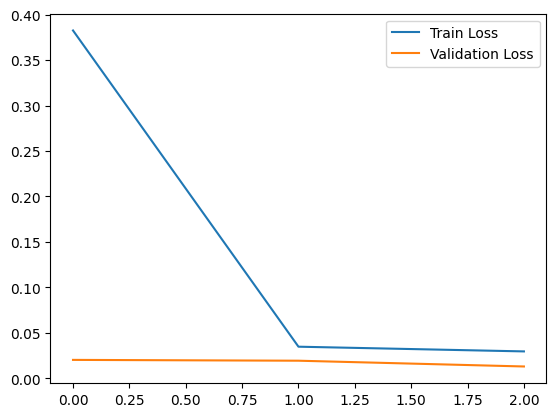

In [20]:
plt.plot(history.history['loss'],label = 'Train Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.show()

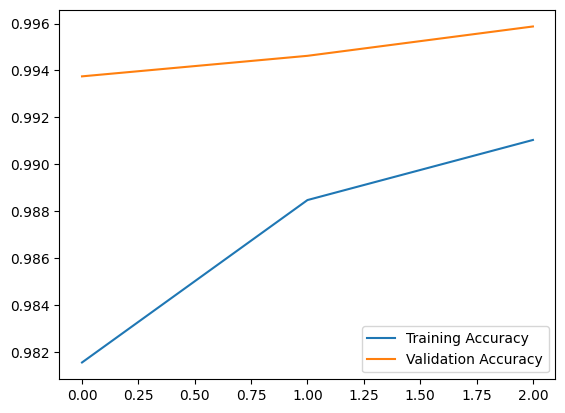

In [21]:
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.show()

## Save Model

In [22]:
from tensorflow.keras.models import save_model

In [23]:
model.save('model_inception_net.keras')

## Test Model

In [24]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = validation_datagen.flow_from_directory(test_path,
                                                        target_size = IMAGE_SIZE,
                                                        batch_size = 32)

Found 12500 images belonging to 1 classes.


In [25]:
y_pred = model.predict(test_set)

391/391 [==============================] - 72s 176ms/step


In [26]:
y_pred

array([[1.00000000e+00, 1.09315285e-14],
       [3.04552633e-03, 9.96954441e-01],
       [2.35362631e-06, 9.99997616e-01],
       ...,
       [9.55218356e-03, 9.90447879e-01],
       [1.00000000e+00, 1.82600422e-13],
       [3.56546188e-05, 9.99964356e-01]], dtype=float32)

In [27]:
y_pred = np.argmax(y_pred,axis = 1)

In [28]:
print(np.unique(y_pred,return_counts=True))

(array([0, 1]), array([6274, 6226]))


In [29]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

In [48]:
def inference_img(img_path):

  z = plt.imread(img_path)
  plt.imshow(z)
  plt.show()

  img = load_img(img_path,target_size = (224,224))
  x = image.img_to_array(img)

  x = np.expand_dims(x,axis = 0)
  img_data = preprocess_input(x)

  y_pred = model.predict(img_data)
  print(y_pred)
  res = np.argmax(y_pred,axis = 1)
  if res[0] == 1:
    prediction = 'Dog'
    print(prediction)
  else:
    prediction = 'Cat'
    print(prediction)

In [49]:
from glob import glob
files = glob('/content/dogcat/test1/test1/*')

In [50]:
files_list = [i for i in files]

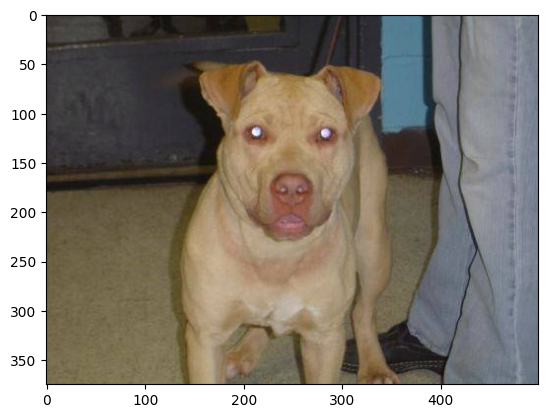

1/1 [==============================] - 0s 38ms/step
[[1.1304744e-06 9.9999893e-01]]
Dog


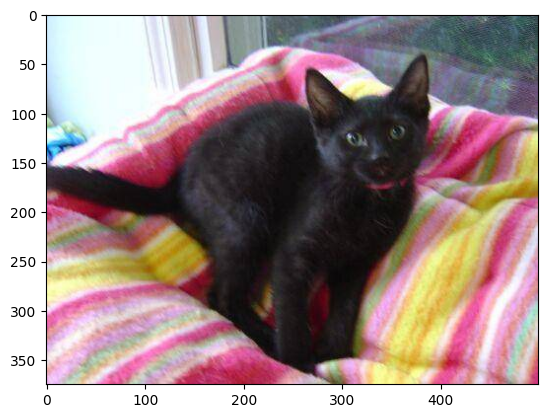

1/1 [==============================] - 0s 47ms/step
[[0.96084684 0.03915319]]
Cat


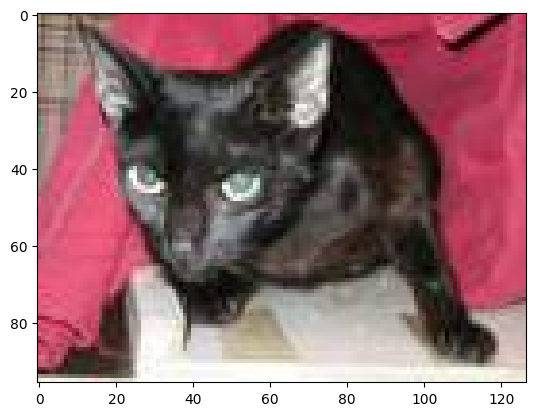

1/1 [==============================] - 0s 37ms/step
[[9.9999845e-01 1.6082206e-06]]
Cat


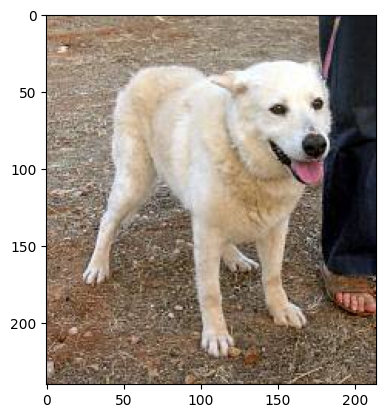

1/1 [==============================] - 0s 36ms/step
[[1.0903515e-05 9.9998915e-01]]
Dog


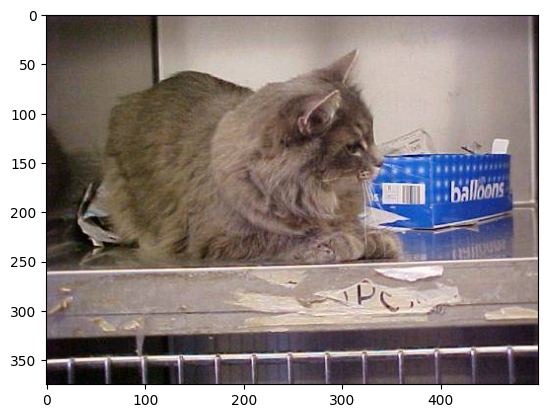

1/1 [==============================] - 0s 51ms/step
[[9.9989223e-01 1.0772929e-04]]
Cat


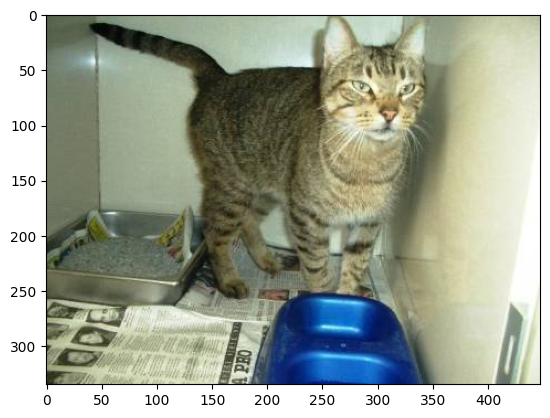

1/1 [==============================] - 0s 49ms/step
[[1.0000000e+00 3.4314531e-09]]
Cat


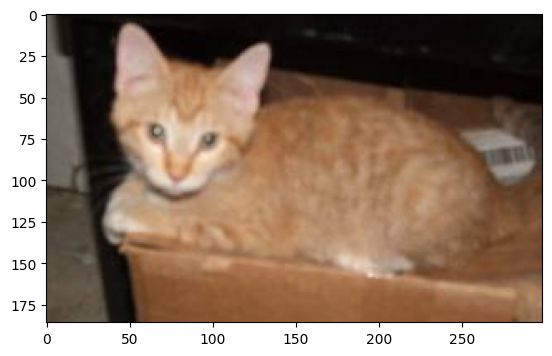

1/1 [==============================] - 0s 37ms/step
[[1.000000e+00 2.483651e-10]]
Cat


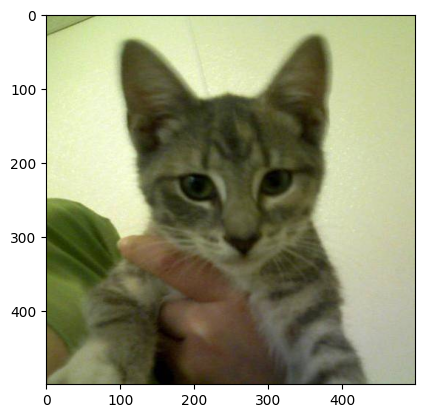

1/1 [==============================] - 0s 41ms/step
[[1.0000000e+00 1.1218804e-10]]
Cat


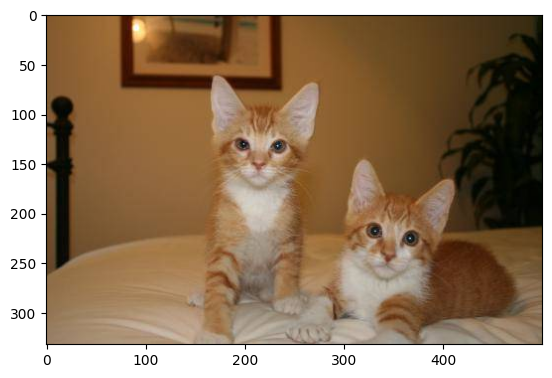

1/1 [==============================] - 0s 47ms/step
[[1.000000e+00 3.724716e-12]]
Cat


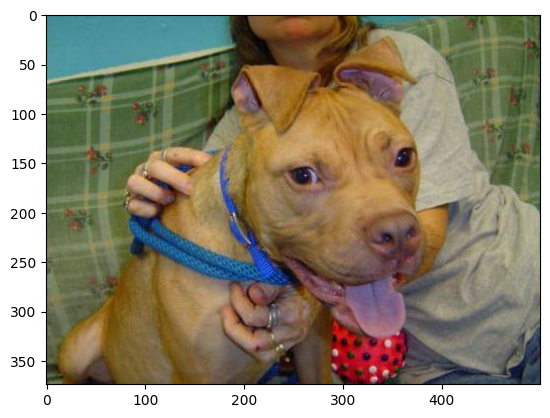

1/1 [==============================] - 0s 57ms/step
[[1.2017245e-04 9.9987984e-01]]
Dog


In [51]:
for i in range(10):
  inference_img(files_list[i])

## Load Model and Test

In [52]:
from tensorflow.keras.models import load_model
from keras.utils import CustomObjectScope

In [53]:
saved_model = load_model('/content/model_inception_net.keras')

In [55]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.utils import load_img

In [56]:
def predict_img(img_path):

  img = load_img(img_path,target_size = (224,224))
  x = image.img_to_array(img)

  x = np.expand_dims(x,axis = 0)
  img_data = preprocess_input(x)

  y_pred = saved_model.predict(img_data)
  print(y_pred)
  res = np.argmax(y_pred,axis = 1)
  if res[0] == 1:
    prediction = 'Dog'
    print(prediction)
  else:
    prediction = 'Cat'
    print(prediction)

In [61]:
from glob import glob
files = glob('/content/dogcat/train/cats/*')

In [64]:
files_list = [i for i in files]

In [63]:
for i in range(10):
  predict_img(files_list[i])

1/1 [==============================] - 0s 40ms/step
[[1.000000e+00 2.409671e-22]]
Cat
1/1 [==============================] - 0s 38ms/step
[[1.0000000e+00 6.1851746e-11]]
Cat
1/1 [==============================] - 0s 40ms/step
[[0.99605954 0.00394047]]
Cat
1/1 [==============================] - 0s 36ms/step
[[9.9998164e-01 1.8390940e-05]]
Cat
1/1 [==============================] - 0s 42ms/step
[[1.0000000e+00 4.3660515e-09]]
Cat
1/1 [==============================] - 0s 37ms/step
[[1.0000000e+00 2.5944736e-24]]
Cat
1/1 [==============================] - 0s 40ms/step
[[1.0000000e+00 1.2591453e-10]]
Cat
1/1 [==============================] - 0s 39ms/step
[[9.9999583e-01 4.1806034e-06]]
Cat
1/1 [==============================] - 0s 36ms/step
[[9.999759e-01 2.402713e-05]]
Cat
1/1 [==============================] - 0s 39ms/step
[[1.0000000e+00 2.9241531e-09]]
Cat
